# Churn Prediction: Tasa de Cancelación de Clientes
En este documento se hace un ejercicio de predicción de la tasa de cancelación de clientes de una empresa de telecomunicaciones. Los datos se obtuvieron del sitio web de Kaggle:
https://www.kaggle.com/contacts365/telco-churn-prediction

En primer lugar se cargan los paquetes a utilizar y se ajusta el formato para los outputs:

In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x) # formato del output, 4 decimales
pd.set_option('display.max_columns', 30) # número máximo de columnas a mostrar en el terminal
pd.set_option('display.max_rows', 20) # número máximo de filas a mostrar en el terminal

Luego se cargan los datos y se hace un exámen inicial. Se tienen 3.333 observaciones y 21 variables. Se tienen variables como el número de minutos consumidos en distintos periodos del día ('Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins'), el número de llamadas y el costo en distintos periodos del día ('Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge'), las llamadas al servicio al cliente ('CustServ_Calls'), si el cliente tiene plan de llamadas internacionales y buzón de voz ('Intl_Plan', 'Vmail_Plan'), Estado, Código de área, Teléfono, entre otras. La variable **'Churn'** indica si el cliente canceló el servicio contratado con la compañía.

Se observa que algunas variables son del tipo 'object', por lo que se deben procesar antes de utilizarlas.

In [50]:
data = pd.read_csv('Churn.csv')
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

En primer lugar se elimina la variable 'Phone', que identifica al usuario pero no aporta en nada a la decisión de cancelar el servicio. También se procesan las variables categóricas: 'Churn', 'Intl_Plan' y 'Vmail_Plan', que se transforman en variables dummy.

In [51]:
data = data.drop('Phone', axis=1)

catV = ['Churn', 'Intl_Plan', 'Vmail_Plan']
data[catV] = data[catV].replace({'no':0, 'yes':1})
print(data.head())

Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25    265.10    197.40      244.70      10.00   
1             107             26    161.60    195.50      254.40      13.70   
2             137              0    243.40    121.20      162.60      12.20   
3              84              0    299.40     61.90      196.90       6.60   
4              75              0    166.70    148.30      186.90      10.10   

   CustServ_Calls  Churn  Intl_Plan  Vmail_Plan  Day_Calls  Day_Charge  \
0               1      0          0           1        110       45.07   
1               1      0          0           1        123       27.47   
2               0      0          0           0        114       41.38   
3               2      0          1           0         71       50.90   
4               3      0          1           0        113       28.34   

   Eve_Calls  Eve_Charge  Night_Calls  Night_Charge  Intl_Calls  Intl_Charge  \
0  

En la siguiente celda se obtienen los promedios de las variables agrupadas según Churn. Se observan algunas diferencias interesantes. Por ejemplo, los clientes que dejaron la compañía (Churn=1) tienen muchas más llamadas a servicio al cliente que aquellos que siguen en la compañía, lo que sugiere que tuvieron problemas de alguna naturaleza. También se observa una mayor contratación del plan de llamadas internacionales, y una menor contratación del buzón de voz en este grupo de clientes. En general, también se observa que consumieron una mayor cantidad de minutos, en todos los horarios, aunque no se aprecian diferencias significativas en el caso de las llamadas internacionales.

In [52]:
print('Promedios según Churn: \n')
data.groupby(data.Churn).mean()

Promedios según Churn: 



,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,Area_Code
Churn,,,,,,,,,,,,,,,,,,
0,100.79,8.60,175.18,199.04,200.13,10.16,1.45,0.07,0.30,100.28,29.78,100.04,16.92,100.06,9.01,4.53,2.74,437.07
1,102.66,5.12,206.91,212.41,205.23,10.70,2.23,0.28,0.17,101.34,35.18,100.56,18.05,100.40,9.24,4.16,2.89,437.82


Luego se analiza la matriz de correlaciones, donde se observa un grupo de variables demasiado correlacionadas con otras, lo que sugiere que contienen la misma información. Por ejemplo, los minutos hablados y el monto cobrado por esos minutos. De hecho, se esperaría que el monto cobrado fuera una función lineal de los minutos consumidos. Por lo tanto, se opta por eliminar las variables redundantes de la base de datos.

In [53]:
print(data.corr())
data = data.drop(['Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins', 'Vmail_Plan'], axis=1)

Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  \
Account_Length            1.00          -0.00      0.01     -0.01       -0.01   
Vmail_Message            -0.00           1.00      0.00      0.02        0.01   
Day_Mins                  0.01           0.00      1.00      0.01        0.00   
Eve_Mins                 -0.01           0.02      0.01      1.00       -0.01   
Night_Mins               -0.01           0.01      0.00     -0.01        1.00   
Intl_Mins                 0.01           0.00     -0.01     -0.01       -0.02   
CustServ_Calls           -0.00          -0.01     -0.01     -0.01       -0.01   
Churn                     0.02          -0.09      0.21      0.09        0.04   
Intl_Plan                 0.02           0.01      0.05      0.02       -0.03   
Vmail_Plan                0.00           0.96     -0.00      0.02        0.01   
Day_Calls                 0.04          -0.01      0.01     -0.02        0.02   
Day_Charge                0.01           0.0

# Preprocesamiento

En la siguiente celda se hace una copia de los datos originales y luego se procesan las variables para ser utilizadas en los análisis de regresión. 

En primer lugar se eliminan las variables 'State' y 'Area Code', que serán procesadas por separado. 

In [54]:
data1 = data.copy()
data1 = data1.drop(['State', 'Area_Code'], axis=1)
print(data1.shape)

(3333, 13)


En la siguiente celda se procesan las variables categóricas, que se transforman en dummies. Luego se elimina una variable dummy de cada set de categorías, y la base de datos se fusiona con la base de datos original. Así, se obtiene una base de datos de mayor dimensión, con 65 variables.

In [55]:
print('States : \n', data['State'].unique(), '\n')
print('Area Codes : \n', data['Area_Code'].unique(), '\n')

State = pd.get_dummies(data['State'])
State = State.drop('AK', axis=1)

Area = pd.get_dummies(data['Area_Code'])
Area = Area.drop(408, axis=1)

data1 = pd.concat([data1, State, Area], axis=1)
print(data1.shape)

States : 
 ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND'] 

Area Codes : 
 [415 408 510] 

(3333, 65)


Luego se divide la base de datos en una set de entrenamiento y otro de testeo. Previamente, se define la variable objetivo, *y*, y la matriz de predictores, *X*.

In [56]:
y = data1['Churn']
X = data1.drop('Churn', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

In [57]:
print(X_train.head())

Account_Length  Vmail_Message  CustServ_Calls  Intl_Plan  Day_Calls  \
3094              91              0               1          0         61   
1844              77             28               4          0        117   
400               98             31               1          0        105   
1408             232              0               1          0        104   
2304              93             32               0          0        120   

      Day_Charge  Eve_Calls  Eve_Charge  Night_Calls  Night_Charge  \
3094       22.75         96       13.50           92          8.53   
1844       23.10        102       20.78           74          9.34   
400        20.57         98       18.61          110         10.20   
1408       28.15        115       16.65           77          5.32   
2304       19.87         97       19.75          112          5.75   

      Intl_Calls  Intl_Charge  AL  AR  AZ  ...  PA  RI  SC  SD  TN  TX  UT  \
3094           2         2.84   0   0   0  .

En la siguiente celda se estandarizan las variables continuas antes de ajustar los algoritmos. Esto se hace después de dividir la muestra para no contaminar el test set con información del training set.

In [58]:
floatV = ['Account_Length', 'Vmail_Message', 'CustServ_Calls', 
          'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 
          'Night_Calls', 'Night_Charge', 'Intl_Calls', 
          'Intl_Charge']

scaler = StandardScaler()
X_train[floatV] = scaler.fit_transform(X_train[floatV])
X_test[floatV] = scaler.transform(X_test[floatV])
print(X_train.describe())

Account_Length  Vmail_Message  CustServ_Calls  Intl_Plan  Day_Calls  \
count         2333.00        2333.00         2333.00    2333.00    2333.00   
mean             0.00           0.00            0.00       0.10      -0.00   
std              1.00           1.00            1.00       0.30       1.00   
min             -2.53          -0.58           -1.19       0.00      -5.06   
25%             -0.69          -0.58           -0.43       0.00      -0.65   
50%             -0.01          -0.58           -0.43       0.00       0.01   
75%              0.66           0.82            0.33       0.00       0.66   
max              3.55           3.17            5.68       1.00       3.21   

       Day_Charge  Eve_Calls  Eve_Charge  Night_Calls  Night_Charge  \
count     2333.00    2333.00     2333.00      2333.00       2333.00   
mean         0.00       0.00        0.00        -0.00          0.00   
std          1.00       1.00        1.00         1.00          1.00   
min         -3.33   

# Análisis de Regresión

A continuación se modela el problema con la primera base de datos. Se usan 3 modelos:
- Logistic Regression
- Random Forest
- XGBoost

In [59]:
# Logistic Regression
lr = LogisticRegression(random_state=123, solver='saga')
parameters = {'C':[0.001, 0.01, 0.1, 1, 100, 500, 1000, 5000, 10000], 
              'penalty':['l1', 'l2']}
searcher = GridSearchCV(lr, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_lr = searcher.best_estimator_
y_pred = best_lr.predict(X_test)
y_pred_proba = best_lr.predict_proba(X_test)[:,1]
Accuracy1 = searcher.score(X_test, y_test)
ROC_AUC1 = roc_auc_score(y_test, y_pred_proba)
F1Score1 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.0s finished
Best CV params {'C': 1, 'penalty': 'l1'}


In [60]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=123)
parameters = {'n_estimators': [100, 350, 500], 'max_features': ['log2', 'sqrt'],
              'min_samples_leaf': [0.10, 0.15, 0.20]}
searcher = GridSearchCV(rf, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_rf = searcher.best_estimator_
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:,1]
Accuracy2 = searcher.score(X_test, y_test)
ROC_AUC2 = roc_auc_score(y_test, y_pred_proba)
F1Score2 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.7s finished
Best CV params {'max_features': 'log2', 'min_samples_leaf': 0.1, 'n_estimators': 100}


In [61]:
# XGBoost Classifier
xgcl = xgb.XGBClassifier(seed=123)
parameters = {'colsample_bytree': [0.3, 0.5, 0.7],
              'n_estimators': [100, 350],
              'max_depth': [2, 4, 6]}
searcher = GridSearchCV(xgcl, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_xgcl = searcher.best_estimator_
y_pred = best_xgcl.predict(X_test)
y_pred_proba = best_xgcl.predict_proba(X_test)[:,1]
Accuracy3 = searcher.score(X_test, y_test)
ROC_AUC3 = roc_auc_score(y_test, y_pred_proba)
F1Score3 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.9s finished
Best CV params {'colsample_bytree': 0.7, 'max_depth': 6, 'n_estimators': 100}


Las medidas de desempeño de los modelos se muestran a continuación. El mejor modelo fue **XGBoost**, en todos los indicadores. 

In [63]:
# Cuadro de evaluaciones
Classifier = ['LR', 'RForest', 'XGBoost']
Accuracy = [Accuracy1, Accuracy2, Accuracy3]
ROC_AUC = [ROC_AUC1, ROC_AUC2, ROC_AUC3]
F1Score = [F1Score1, F1Score2, F1Score3]
Resultados1 = pd.DataFrame({'Accuracy':Accuracy, 'ROC AUC':ROC_AUC, 'F1Score':F1Score}, index=Classifier)
print(Resultados1.idxmax())
Resultados1

Accuracy    XGBoost
ROC AUC     XGBoost
F1Score     XGBoost
dtype: object


,Accuracy,ROC AUC,F1Score
LR,0.87,0.81,0.33
RForest,0.85,0.77,0.00
XGBoost,0.96,0.93,0.85


# Análisis con una segunda base de datos
A continuación se repite el análisis, pero considerando una base de datos que sólo contiene variables continuas. En otras palabras, se descartan las variables dummy de Estado y Area Code, con el objetivo de verificar cómo afecta incluir estas variables en el desempeño de algoritmos como el Random Forest y XGBoost.

In [73]:
X_train = X_train[['Account_Length', 'Vmail_Message', 'CustServ_Calls', 'Intl_Plan', 'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge']]
X_test = X_test[['Account_Length', 'Vmail_Message', 'CustServ_Calls', 'Intl_Plan', 'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge']]

In [75]:
# Logistic Regression
lr = LogisticRegression(random_state=123, solver='saga')
parameters = {'C':[0.001, 0.01, 0.1, 1, 100, 500, 1000, 5000, 10000], 
              'penalty':['l1', 'l2']}
searcher = GridSearchCV(lr, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_lr = searcher.best_estimator_
y_pred = best_lr.predict(X_test)
y_pred_proba = best_lr.predict_proba(X_test)[:,1]
Accuracy1 = searcher.score(X_test, y_test)
ROC_AUC1 = roc_auc_score(y_test, y_pred_proba)
F1Score1 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    4.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.2s finished
Best CV params {'C': 100, 'penalty': 'l1'}


In [76]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=123)
parameters = {'n_estimators': [100, 350, 500], 'max_features': ['log2', 'sqrt'],
              'min_samples_leaf': [0.10, 0.15, 0.20]}
searcher = GridSearchCV(rf, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_rf = searcher.best_estimator_
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:,1]
Accuracy2 = searcher.score(X_test, y_test)
ROC_AUC2 = roc_auc_score(y_test, y_pred_proba)
F1Score2 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.0s finished
Best CV params {'max_features': 'log2', 'min_samples_leaf': 0.1, 'n_estimators': 100}


In [78]:
# XGBoost Classifier
xgcl = xgb.XGBClassifier(seed=123)
parameters = {'colsample_bytree': [0.3, 0.5, 0.7],
              'n_estimators': [100, 350],
              'max_depth': [2, 4, 6]}
searcher = GridSearchCV(xgcl, parameters, n_jobs=-1, verbose=1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

best_xgcl = searcher.best_estimator_
y_pred = best_xgcl.predict(X_test)
y_pred_proba = best_xgcl.predict_proba(X_test)[:,1]
Accuracy3 = searcher.score(X_test, y_test)
ROC_AUC3 = roc_auc_score(y_test, y_pred_proba)
F1Score3 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    4.8s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.3s finished
Best CV params {'colsample_bytree': 0.7, 'max_depth': 4, 'n_estimators': 100}


En la siguiente celda se muestra la tabla de resultados. Se observa que el desempeño prácticamente no cambió respecto de la tabla anterior, lo que sugiere que la contribución de las dummies a mejorar el desempeño del algoritmo es marginal, casi nula. Por lo tanto, se optará por modelar la tasa de Churn usando la segunda base datos, que es más parsimoniosa.

In [79]:
# Cuadro de evaluaciones
Classifier = ['LR', 'RForest', 'XGBoost']
Accuracy = [Accuracy1, Accuracy2, Accuracy3]
ROC_AUC = [ROC_AUC1, ROC_AUC2, ROC_AUC3]
F1Score = [F1Score1, F1Score2, F1Score3]
Resultados2 = pd.DataFrame({'Accuracy':Accuracy, 'ROC AUC':ROC_AUC, 'F1Score':F1Score}, index=Classifier)
print(Resultados2.idxmax())
Resultados2

Accuracy    XGBoost
ROC AUC     XGBoost
F1Score     XGBoost
dtype: object


,Accuracy,ROC AUC,F1Score
LR,0.87,0.81,0.31
RForest,0.85,0.78,0.00
XGBoost,0.96,0.92,0.87


# Análisis de importancia de las variables
Por último, se analiza la importancia de las variables en las predicciones de cada modelo.

En el caso de la regresión logística, la magnitud de los coeficientes señala la medida en que influye en el resultado, en conjunto con el signo. Los coeficientes con signo positivo aumentan la probabilidad de que un caso sea clasificado como 'Churn', y viceversa. Se observa que la variable que más influye en la pérdida de clientes es la contratación del plan internacional, seguido por el costo pagado por las llamadas durante el día, y los minutos de llamadas a servicio al cliente. También se observa que los minutos de llamadas internacionales y los mensajes de voz reducen la probabilidad de Churn.

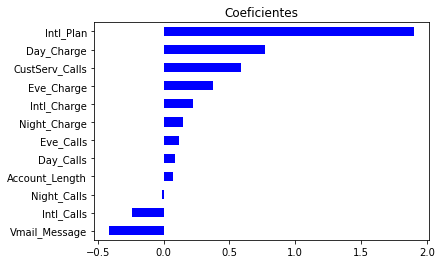

In [85]:
# Logistic Regression
lr = LogisticRegression(random_state=123, solver='saga', C=100, penalty='l1')
lr.fit(X_train, y_train)

coeficientes = pd.DataFrame(data=lr.coef_.reshape(-1,1), index=X_train.columns, columns=['Coeficientes'])
coeficientes = coeficientes.sort_values(by='Coeficientes')
coeficientes.plot(kind='barh', color='blue', legend=False)
plt.title('Coeficientes')
plt.show()

Luego se repite el análisis para el Random Forest. En este caso el costo pagado por las llamadas durante el día fue el mejor predictor de Churn, seguido de las llamadas al servicio al cliente y los pagos por llamadas al anochecer.

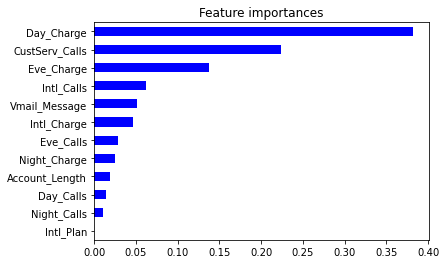

In [88]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=123, max_features='log2', min_samples_leaf=0.1, n_estimators=100)
rf.fit(X_train, y_train)

importances_rf = pd.Series(rf.feature_importances_, index=X_train.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.show()

Por último, en el caso de XGBoost, el mejor clasificador, se observa que la contratación del plan internacional, llamadas a servicio al cliente y costo pagado por llamadas durante el día son los mejores predictores de la fuga de clientes.

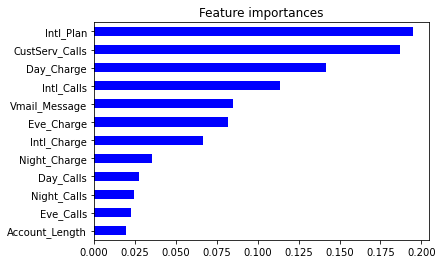

In [89]:
# XGBoost Classifier
xgcl = xgb.XGBClassifier(seed=123, colsample_bytree=0.7, max_depth=4, n_estimators=100)
xgcl.fit(X_train, y_train)

importances_xgcl = pd.Series(xgcl.feature_importances_, index=X_train.columns)
sorted_importances_xgcl = importances_xgcl.sort_values()
sorted_importances_xgcl.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.show()